<font size="6">Introduction</font>

This dataset provides information about all the Airbnb properties located in Bristol. It is composed by 2375 entries, with 28 features each. I will take a look at these variables, but first I have to load the packages that I will use and the dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score

In [2]:
airbnb = pd.read_csv('BristolAirbnbListings.csv')

In [3]:
pd.options.display.max_columns = 28
airbnb.head(3)

,id,name,host_id,host_name,neighbourhood,postcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,availability_365
0,70820,City View - Sarah's double room.,360195,Sarah,Windmill Hill,BS3 4,51.439942,-2.591726,Townhouse,Private room,2,1,1,1,27,4,130,2018-09-28,2.10,96,10,9,10,10.0,10.0,10.0,5,44
1,117122,City Centre - Waterside Retreat,591555,Marcus,Clifton,BS8 4UJ,51.450512,-2.610536,Apartment,Private room,4,2,1,2,65,1,126,2018-10-28,1.40,99,10,10,10,10.0,10.0,10.0,1,360
2,146407,Sunny Central Artist Cottage (Dbl),708175,Orla,Southville,BS3,51.441308,-2.602706,Townhouse,Private room,3,1,1,2,38,2,57,2018-09-12,0.76,91,9,8,9,10.0,9.0,9.0,2,46


Above we have the dataset and its first three entries and, in short, these are the variables:

• Identification variables. They will not be useful for my analysis.

• Location variables. Four features that express the location of the property.

• Property and room type. They provide information about the basic characteristics of the accommodation. There are 24 types      of properties and 3 types of rooms. 

• Accommodates, bathrooms, bedrooms, and beds.

• Price per night.

• Availability variables, containing the minimum number of nights and how many days per year the property is available.

• Review variables. There is a general review score and 6 variables regarding the review of specific aspects of the property, like its cleanliness or location. 


Knowing what is included in the dataset, I decided to perform two different analysis. Firstly, I will use different regression techniques to predict the price per night of the properties, something that could be useful for hosts. They can know, given the characteristics of their property, what would be a competitive price, compared to the price that guests are paying for similar accommodation. By doing so, they may avoid setting a lower or higher rate than the market price. 



On the second analysis I will use regression techniques as in the first analysis, but only using the reviews data. The aim of this analysis is to model the general review score using the review sub-scores. But, instead of creating the models for making predictions, I will rather use them to see which sub-scores explain better the general score. This will be useful for hosts. If they identify what the clients consider more important when using Airbnb, they will get better reviews and, therefore, more clients and profits. 


<font size="6">Data cleaning and visualitation</font>

Before starting with those analyses, I must clean the data and visualize its basic features.

Firstly, I am deleting the variables that are not going to be useful for any of my purposes. The deleted variables will be the identification variables, which are only used to identify the property and its owner, and the last review date.

In [4]:
del airbnb["id"]
del airbnb["name"]
del airbnb["host_id"]
del airbnb["host_name"]
del airbnb["last_review"]

Now I am going to check the type of data of each column and to convert the data into a more suitable type whether it is necessary. 

In [5]:
airbnb.dtypes

neighbourhood                      object
postcode                           object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                       object
bathrooms                          object
bedrooms                           object
beds                               object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
review_scores_rating               object
review_scores_accuracy             object
review_scores_cleanliness          object
review_scores_checkin              object
review_scores_communication       float64
review_scores_location            float64
review_scores_value               float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [6]:
#Converting review scores from object to numeric.
airbnb["review_scores_rating"] = pd.to_numeric(airbnb["review_scores_rating"], errors = "coerce")
airbnb["review_scores_accuracy"] = pd.to_numeric(airbnb["review_scores_accuracy"], errors = "coerce")
airbnb["review_scores_cleanliness"] = pd.to_numeric(airbnb["review_scores_cleanliness"], errors = "coerce")
airbnb["review_scores_checkin"] = pd.to_numeric(airbnb["review_scores_checkin"], errors = "coerce")


In [7]:
airbnb["room_type"] = airbnb["room_type"].astype("category")
airbnb["property_type"] = airbnb["property_type"].astype("category")

                      

In [8]:
airbnb["accommodates"] = pd.to_numeric(airbnb["accommodates"], errors = "coerce")
airbnb["bathrooms"] = pd.to_numeric(airbnb["bathrooms"], errors = "coerce")
airbnb["bedrooms"] = pd.to_numeric(airbnb["bedrooms"], errors = "coerce")
airbnb["beds"] = pd.to_numeric(airbnb["beds"], errors = "coerce")


Having converted the data, I will check now if there are missing values and outliers on the dataset.

In [9]:
#Finding missing values
pd.isnull(airbnb).sum()

neighbourhood                       0
postcode                           49
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                       22
bathrooms                           6
bedrooms                            4
beds                                4
price                               0
minimum_nights                      0
number_of_reviews                   0
reviews_per_month                 306
review_scores_rating              356
review_scores_accuracy            340
review_scores_cleanliness         339
review_scores_checkin             341
review_scores_communication       338
review_scores_location            340
review_scores_value               340
calculated_host_listings_count      0
availability_365                    0
dtype: int64

There are plenty of missing values for the review scores, apart from some other NaN in postcode, accommodates and in other variables. Firstly I will delete the rows without a value for "review scores rating" because its the variable with most missing values and, hopefully, the NaNs of other features will be removed.

In [10]:
#Deleting empty rows. After running this I notice that, fortunately, the same rows lack from all the revies score
 
airbnb = airbnb.dropna(subset = ['review_scores_rating'])


In [11]:
pd.isnull(airbnb).sum()

neighbourhood                      0
postcode                          39
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       1
bathrooms                          3
bedrooms                           4
beds                               3
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
review_scores_rating               0
review_scores_accuracy             1
review_scores_cleanliness          2
review_scores_checkin              4
review_scores_communication        1
review_scores_location             3
review_scores_value                3
calculated_host_listings_count     0
availability_365                   0
dtype: int64

With that action, I almost removed all the missing values in the dataset. Now what I will do is to drop the postcode variable, because it has some missing values and it is possibly highly correlated with the neighbourhood variable, which has no missing values. In fact, having a significant correlation between variables can affect negatively to some models.

In [12]:
del airbnb["postcode"]

Now, provided that there are only a few values missing, I will replace the NaNs with the median value of the feature. 
This will be done for all the variables with missing values that we can see in the above output. 

In [13]:
#Changing missing values with the median. There are just a few values missing, 
beds_median = airbnb["beds"].median()
bath_median = airbnb["bathrooms"].median()
bedr_mediean = airbnb["bedrooms"].median()
acc_median = airbnb["accommodates"].median()
airbnb["beds"].fillna(beds_median, inplace=True)
airbnb["bathrooms"].fillna(bath_median, inplace=True)
airbnb["bedrooms"].fillna(bath_median, inplace=True)
airbnb["accommodates"].fillna(bath_median, inplace=True)

In [14]:
acc_median = airbnb["review_scores_accuracy"].median()
cle_median = airbnb["review_scores_cleanliness"].median()
check_median = airbnb["review_scores_checkin"].median()
comm_median = airbnb["review_scores_communication"].median()
loca_median = airbnb["review_scores_location"].median()
value_median = airbnb["review_scores_value"].median()
airbnb["review_scores_accuracy"].fillna(acc_median, inplace=True)
airbnb["review_scores_cleanliness"].fillna(cle_median, inplace=True)
airbnb["review_scores_checkin"].fillna(check_median, inplace=True)
airbnb["review_scores_communication"].fillna(comm_median, inplace=True)
airbnb["review_scores_location"].fillna(loca_median, inplace=True)
airbnb["review_scores_value"].fillna(value_median, inplace=True)

Now there are no NaNs on the dataset. Now I will check how many observations I lost, and then I will start to look for outliers whithin the dataset.

In [15]:
len(airbnb)

2019

I went from 2375 rows to 2019, which means that I lost almost 15% of the observations. Now I will produce some plots to look for outliers, starting with a box plot of the price. As we see, there are some values far away from the average. 

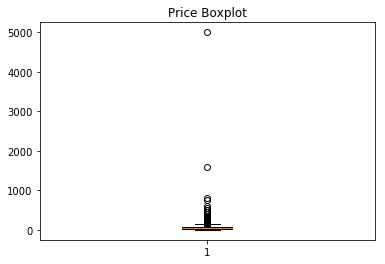

In [16]:
plt.boxplot(airbnb['price'])
plt.title("Price Boxplot")
plt.show()

There are at least two clear outliers. I will check the features of the observations with a high price and check whether the high cost is "explained" by some of the features or it is indeed an outlier.

In [17]:
airbnb[airbnb["price"] >= 500]

,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,availability_365
859,Ashley,51.463463,-2.585318,Townhouse,Entire home/apt,16.0,3.0,7.0,13.0,799,1,41,2.04,98.0,10.0,10.0,10.0,10.0,9.0,9.0,9,235
976,Easton,51.468726,-2.557538,House,Entire home/apt,8.0,1.5,5.0,7.0,550,1,4,0.22,100.0,9.0,10.0,10.0,10.0,9.0,8.0,2,363
1240,Hotwells & Harbourside,51.454807,-2.604969,Apartment,Entire home/apt,16.0,4.0,4.0,14.0,500,1,21,1.49,97.0,10.0,10.0,10.0,10.0,10.0,9.0,12,173
1345,Central,51.456477,-2.604660,Apartment,Entire home/apt,16.0,5.0,5.0,16.0,500,1,9,1.21,98.0,10.0,10.0,10.0,10.0,10.0,10.0,12,169
1482,Brislington East,51.441210,-2.536662,Villa,Entire home/apt,16.0,12.5,13.0,24.0,1600,1,15,2.01,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,113
1659,Ashley,51.465065,-2.584095,Apartment,Entire home/apt,10.0,2.0,3.0,10.0,600,1,1,1.00,60.0,6.0,10.0,10.0,8.0,8.0,6.0,3,355
1809,Central,51.461313,-2.593283,Serviced apartment,Entire home/apt,2.0,1.0,1.0,1.0,750,1,1,0.29,100.0,10.0,10.0,10.0,10.0,10.0,10.0,14,354
2201,Windmill Hill,51.438067,-2.595130,Townhouse,Entire home/apt,13.0,1.5,4.0,10.0,5000,1,1,1.00,100.0,8.0,10.0,10.0,10.0,10.0,8.0,5,350


Seeing this information, I am going to drop the rows in which the price is bigger than 500. Although these observations seem real, they are really uncommon. Here, I am dealing with very big properties that can allocate a big number of accommodates. 
As long as there are only 7 observations, I do not lose a big part of the data, and my models will be more accurate. 

In [18]:
airbnb = airbnb[airbnb["price"] <= 500]

In [19]:
airbnb = airbnb[airbnb["price"] > 0]

I have also checked is there is any price equal (or less) to zero, and actually there is one value. I proceeded to drop it. 

In [20]:
len(airbnb)

2012

Now my dataset is composed of 2012 entries, so I have not lost many rows dealing with the outliers. Below I have plotted the final distribution of the price (although it may change a bit if I change or delete rows in the next steps). 

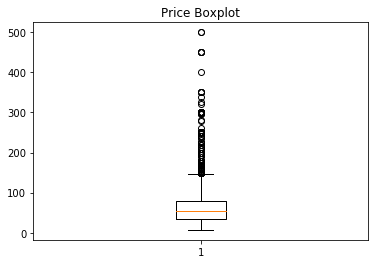

In [21]:
plt.boxplot(airbnb['price'])
plt.title("Price Boxplot")
plt.show()

Now I am taking a look at the other variables with possible outliers or wrong entries. It will also be useful for getting a first insight of these variables.

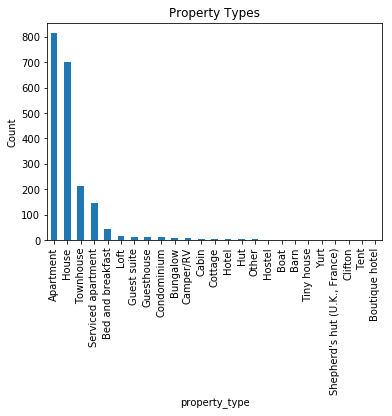

In [22]:
property_types = airbnb["property_type"].value_counts()
property_types = property_types[property_types > 0] #There is no observations for some of the property types.
property_types.plot.bar()
plt.xlabel("property_type")
plt.ylabel("Count")
plt.title("Property Types")
plt.show()


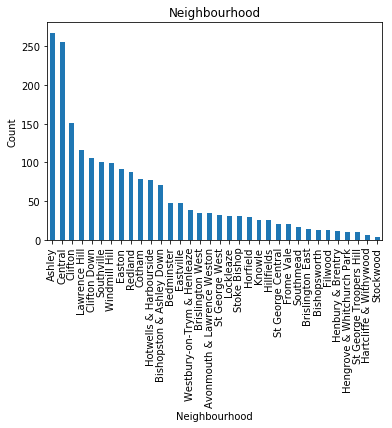

In [23]:
airbnb["neighbourhood"].value_counts().plot.bar()
plt.xlabel("Neighbourhood")
plt.ylabel("Count")
plt.title("Neighbourhood")
plt.show()


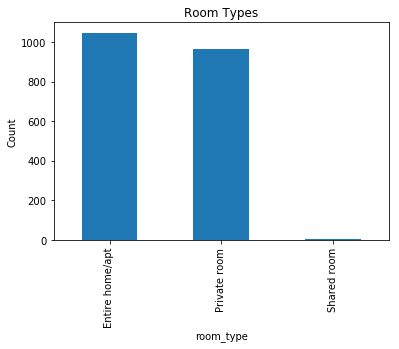

In [24]:
airbnb["room_type"].value_counts().plot.bar()
plt.xlabel("room_type")
plt.ylabel("Count")
plt.title("Room Types")
plt.show()

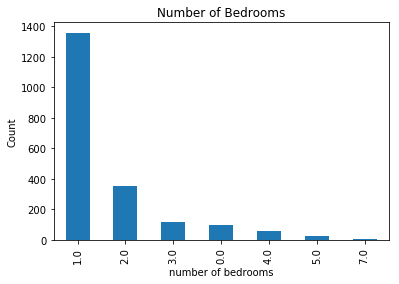

In [25]:
airbnb["bedrooms"].value_counts().plot.bar()
plt.xlabel("number of bedrooms")
plt.ylabel("Count")
plt.title("Number of Bedrooms")
plt.show()


Here there is a problem, the dataset has some observations in which the number of bedrooms is 0. This can be correct or not, so I will take a look into the characteristics of the rows with 0 bedrooms and then I will decide what to do with them. 

In [26]:
bed_0 = airbnb[airbnb["bedrooms"] == 0]
bed_0.head(5)

,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,availability_365
98,Frome Vale,51.483552,-2.526815,Townhouse,Private room,1.0,1.0,0.0,1.0,30,1,9,0.17,95.0,10.0,10.0,10.0,10.0,10.0,9.0,1,88
130,Brislington East,51.451656,-2.545024,Apartment,Entire home/apt,2.0,1.0,0.0,1.0,65,2,90,1.93,91.0,10.0,9.0,10.0,10.0,9.0,9.0,1,289
243,Clifton,51.457606,-2.618214,Loft,Entire home/apt,2.0,1.0,0.0,1.0,70,2,67,1.70,98.0,10.0,10.0,10.0,10.0,10.0,9.0,1,272
257,Ashley,51.459291,-2.585784,Apartment,Entire home/apt,2.0,1.0,0.0,1.0,75,3,16,0.42,93.0,10.0,9.0,10.0,9.0,10.0,9.0,9,360
326,Central,51.453223,-2.593276,Apartment,Entire home/apt,2.0,1.0,0.0,1.0,62,2,162,4.73,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2,349


I will check the property type and, based on this and the number of accommodates, I am going to define some rules arbitrarily to assign a number of rooms to each row.

In [27]:
unique, counts = np.unique(bed_0["property_type"], return_counts=True)
dict(zip(unique, counts))

{'Apartment': 51,
 'Condominium': 1,
 'Guest suite': 4,
 'House': 7,
 'Hut': 1,
 'Loft': 2,
 'Serviced apartment': 26,
 'Townhouse': 2,
 'Yurt': 1}

In [28]:
unique, counts = np.unique(bed_0["accommodates"], return_counts=True)
dict(zip(unique, counts))

{1.0: 6, 2.0: 73, 3.0: 1, 4.0: 8, 6.0: 4, 7.0: 2, 8.0: 1}

Checking the property types and the number of accommodates, I decided to set the following rules:
1.  Each room can accommodate two people. So, a property for two guests will have 1 room, a property for three people will have 2 rooms and so on.
2. There are some types of properties that are only composed of a big room. Those are "Hut", "Loft" and "Yurt".
3. I am supposing that the type of property "guest suite" is just composed by 1 bedroom. 

In [29]:
rule_1 = (airbnb['accommodates'] == 1) & (airbnb['property_type'] != "Loft") & (airbnb['property_type'] != "Yurt") & (airbnb['property_type'] != "Hut") & (airbnb['property_type'] != "Guest suite")
airbnb.loc[rule_1, 'bedrooms'] = 1
rule_2 = (airbnb['accommodates'] == 2) & (airbnb['property_type'] != "Loft") & (airbnb['property_type'] != "Yurt") & (airbnb['property_type'] != "Hut") & (airbnb['property_type'] != "Guest suite")
airbnb.loc[rule_2, 'bedrooms'] = 1
rule_3 = (airbnb['accommodates'] == 3) & (airbnb['property_type'] != "Loft") & (airbnb['property_type'] != "Yurt") & (airbnb['property_type'] != "Hut") & (airbnb['property_type'] != "Guest suite")
airbnb.loc[rule_3, 'bedrooms'] = 2
rule_4 = (airbnb['accommodates'] == 4) & (airbnb['property_type'] != "Loft") & (airbnb['property_type'] != "Yurt") & (airbnb['property_type'] != "Hut") & (airbnb['property_type'] != "Guest suite")
airbnb.loc[rule_4, 'bedrooms'] = 2
rule_5 = (airbnb['accommodates'] == 6) & (airbnb['property_type'] != "Loft") & (airbnb['property_type'] != "Yurt") & (airbnb['property_type'] != "Hut") & (airbnb['property_type'] != "Guest suite")
airbnb.loc[rule_5, 'bedrooms'] = 3
rule_6 = (airbnb['accommodates'] == 7) & (airbnb['property_type'] != "Loft") & (airbnb['property_type'] != "Yurt") & (airbnb['property_type'] != "Hut") & (airbnb['property_type'] != "Guest suite")
airbnb.loc[rule_6, 'bedrooms'] = 4
rule_7 = (airbnb['accommodates'] == 8) & (airbnb['property_type'] != "Loft") & (airbnb['property_type'] != "Yurt") & (airbnb['property_type'] != "Hut") & (airbnb['property_type'] != "Guest suite")
airbnb.loc[rule_7, 'bedrooms'] = 4
rule_8 = (airbnb['property_type'] == "Guest suite")
airbnb.loc[rule_8, 'bedrooms'] = 1

In [30]:
airbnb[airbnb["bedrooms"] == 0]

,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,availability_365
243,Clifton,51.457606,-2.618214,Loft,Entire home/apt,2.0,1.0,0.0,1.0,70,2,67,1.70,98.0,10.0,10.0,10.0,10.0,10.0,9.0,1,272
1303,Ashley,51.465348,-2.587885,Hut,Private room,1.0,1.0,0.0,1.0,22,1,90,6.63,95.0,10.0,10.0,9.0,9.0,10.0,10.0,2,227
1470,Clifton Down,51.460421,-2.613466,Loft,Entire home/apt,4.0,1.0,0.0,2.0,76,2,63,6.34,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1,21
1821,Ashley,51.474165,-2.576801,Yurt,Entire home/apt,6.0,0.5,0.0,1.0,200,2,9,2.14,91.0,10.0,9.0,10.0,10.0,10.0,10.0,3,112


After applying the rules, now there are only 4 observations with zero rooms in the dataset, but the lack of rooms seems to be justified by the property type. 

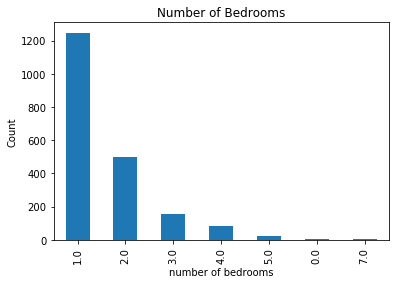

In [31]:
airbnb["bedrooms"].value_counts().plot.bar()
plt.xlabel("number of bedrooms")
plt.ylabel("Count")
plt.title("Number of Bedrooms")
plt.show()

The graph below shows the distribution of the rating. As we seen, all the ratings are located in really high scores. It is probably because clients do not go to properties that receive bad reviews and, therefore, these properties are retired from the market by their owners.

C:\Users\Diego\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


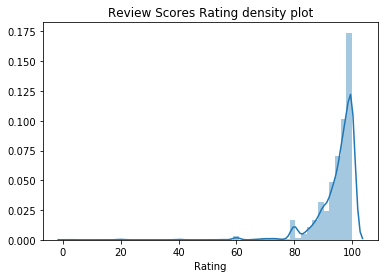

In [32]:
sns.distplot(airbnb['review_scores_rating'])
plt.title("Review Scores Rating density plot")
plt.xlabel("Rating")
plt.show()

Apart from the number of bedrooms, I do not find other possible problems to tackle. The categories in the firsts plot seem to be fine. Although there are some uncommon categories (in "property type" and "neighbourhood"), I am going to use this features as independent variables, so I will keep them because the model will not have to predict these categories. 


Now my data is cleaned and ready to performing the analysis. But before starting with them, I will finish the visualization section providing some plots in other variables.

The next two plots represent the geographical distribution of the properties; on the first one, they are represented by density (the strongest the color the higher the density) and by price. 

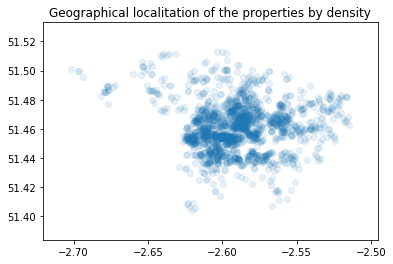

In [33]:
plt.scatter(x=airbnb['longitude'], y=airbnb['latitude'], alpha=0.1)
plt.title("Geographical localitation of the properties by density")
plt.show()

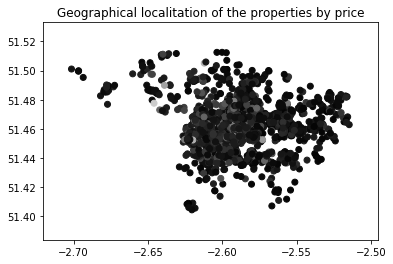

In [34]:
plt.scatter(x=airbnb['longitude'], y=airbnb['latitude'], c=airbnb['price'])
plt.gray()
plt.title("Geographical localitation of the properties by price")
plt.show()


As we can see, there is a clear concentration of properties in same area of the city, but the most expensives ones seems to be out of that area.

Below there are three correlation matrices that show the correlation between the variables of the dataset. It is split into three matrices for the sake of simplicity.

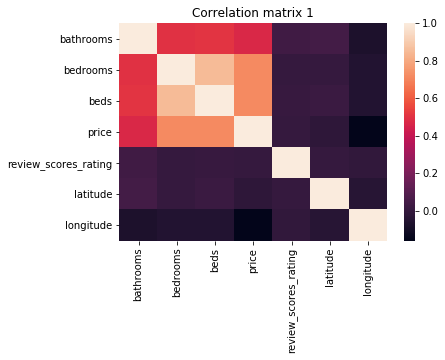

In [35]:
correlationdata1 = airbnb[["bathrooms", "bedrooms", "beds","price", "review_scores_rating", "latitude", "longitude"]]
correlation = correlationdata1.corr()
sns.heatmap(correlation)
plt.title("Correlation matrix 1")
plt.show()

From this first correlation matrix, we can spot significant correlations between bathrooms, bedrooms, beds, and price, something that will be relevant for the first analysis. Surprisingly, the review rate is not correlated with those variables. We will see in one of the analyses which variables explain the review scores that the guests provide. 

In [36]:
airbnb_copy = airbnb.copy()

In [37]:
#Getting dummies of room types 
airbnb_RT = pd.get_dummies(airbnb["room_type"])
airbnb_copy = pd.concat([airbnb_copy, airbnb_RT], axis=1)


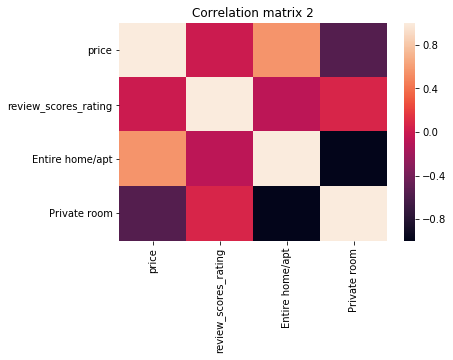

In [38]:
correlationdata2 = airbnb_copy[["price", "review_scores_rating","Entire home/apt", "Private room"]]
correlation2 = correlationdata2.corr()
sns.heatmap(correlation2)
plt.title("Correlation matrix 2")
plt.show()

On this second matrix we see a positive correlation between the price and renting the whole flat. We see again that the review score is not highly correlated with any of the variables.

As there is no correlation between the ratings and the price, I will weight the rating using the number of reviews per month and check if this variable is correlated with the price.

In [39]:
airbnb['Weighted Review'] = (airbnb['reviews_per_month']*airbnb['review_scores_rating'])/100
airbnb['Weighted Review'].corr(airbnb['price'])

-0.07681085085614084

As it is not correlated, I will delete it.

In [40]:
del airbnb['Weighted Review']

<font size="6">First Analysis: Predictive model for the price</font>

<font size="4">Feature selection and data preparation</font>

As I explained in the introduction, in the first analysis I will use different regression models with the aim of creating predictive models for the price of the accommodation. The regression techniques that I am going to use are linear regression, ridge regression, support vector (using different algorithms) and random forest regression. These models will be validated using k-folds cross-validation, which will determine if the models are accurate. 

Before performing the regressions, I will prepare the data. This will include taking dummies for the type of room and property. 

In [41]:
airbnb_3 = airbnb.copy()

Now I am going to scale the data. The variables of the model are in a range of different magnitudes, something that affects negatively some types of machine learning models. For avoiding this problem, the data will be standardized, each feature will have a mean of zero and a standard deviation of one.

But prior to doing so, I will take dummies of the room and property type. These variables will be either a 1 or a 0 for each row, so there is no need in scaling them.

I will also delete the variables that I am not going to use in my model.

In [42]:
room_t = pd.get_dummies(airbnb_3["room_type"])
property_t = pd.get_dummies(airbnb_3["property_type"])

In [43]:
del airbnb_3["neighbourhood"], airbnb_3["latitude"], airbnb_3["longitude"], airbnb_3["property_type"], airbnb_3["room_type"]

In [44]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
num_attribs = list(airbnb_3)
airbnb_3[num_attribs] = ss.fit_transform(airbnb_3[num_attribs])

In [45]:
airbnb_3_lin = pd.concat([airbnb_3, room_t, property_t], axis=1)

Now I will do the feature selection. I want to use all the possible independent variables. But using all the variables that I have in the dataset may cause problems. Some models suffer from multicollinearity, a problem that arises when the dependent variables of the model are correlated between them. Knowing this, I will only use a variable regarding the reviews (the general score) and the review score for the location because I want to use variable regarding the location of the property. I will also drop one of the dummies for room type because "entire home/apt" and "private room" are almost perfectly negatively correlated.  

In [46]:
dependent = airbnb_3_lin["price"]

In [47]:
del airbnb_3_lin["t"], airbnb_3_lin["f"], airbnb_3_lin["price"], airbnb_3_lin["Private room"], airbnb_3_lin["review_scores_accuracy"], airbnb_3_lin["review_scores_cleanliness"], airbnb_3_lin["review_scores_checkin"], airbnb_3_lin["review_scores_communication"], airbnb_3_lin["review_scores_value"]

The next step is splitting the data into training and test. The model will learn from the training set, and the test data will be used for making a prediction based on the model.

In [48]:
from sklearn import model_selection
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(airbnb_3_lin, dependent, test_size=0.3)

<font size="4">Fitting the models</font>

Below we have the linear regression model and its scoring. The chosen measure for scoring is the negative mean squared error, which means that the higher the score (the closer to zero), the better. 
This score will be obtained multiple times using k-folds cross-validation. This is a resampling procedure that creates k splits of data. Therefore, we will have k pairs of training and testing data. The model will be fitted for each pair, and the performance will be tested with the training data. This will give k different scores.

I am going to use this procedure for each of the models used in this section, and at the end, I will use it to compare the performance of those models.

In [49]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
cv_scores_linear = cross_val_score(lin_reg, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

Now I will fit a Ridge Regression. It is a regularized version of the linear regression. It introduces a regularization term that forces the algorithm to keep the model weights as small as possible. 

In [51]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.01, normalize=True)
ridge.fit(X_train, Y_train)
cv_scores_rid = cross_val_score(ridge, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

The next model to test is the support vector machine regression. This model can be used for classification and regression. In classification, the model tries to find the largest decision boundary between classes of data, although it may allow some violations of the margin. On the other side, in regression tasks, the model will fit as many instances as possible inside the decision boundary. 

This model supports different kernels to fit the model. I am going to use the linear, polynomial and the Gaussian Radial Basis kernel, which is used to deal with non-linear data. 

In [52]:
from sklearn.svm import SVR
#Linear
svr_reg =SVR(kernel="linear")
svr_reg.fit(X_train,Y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [53]:
cv_scores_svr = cross_val_score(svr_reg, X_train, Y_train, cv=5, scoring = 'neg_mean_squared_error')

In [54]:
#Polynomial Function
svr_reg =SVR(kernel="poly")
svr_reg.fit(X_train,Y_train)
prediction = svr_reg.predict(X_test)

In [55]:
cv_scores_svr_poly = cross_val_score(svr_reg, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

In [56]:
#Radial Basis Function
svr_reg =SVR(kernel="rbf")
svr_reg.fit(X_train,Y_train)
prediction = svr_reg.predict(X_test)
cv_scores_svr_rbf = cross_val_score(svr_reg, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

The last model that I will use is Random Forest. It is an ensemble of Decision Trees that, instead of splitting the data using the best possible feature, it choose the best feature within a subset of features.

In [57]:
#Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, Y_train)
prediction = rf_reg.predict(X_test)

C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [58]:
cv_scores_rf = cross_val_score(rf_reg, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

<font size="4">Results</font>


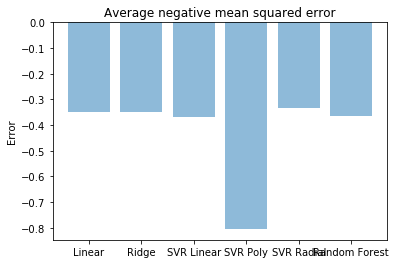

In [59]:
results = cv_scores_linear.mean(), cv_scores_rid.mean(), cv_scores_svr.mean(), cv_scores_svr_poly.mean(),cv_scores_svr_rbf.mean(),cv_scores_rf.mean()
objects = ('Linear', 'Ridge', 'SVR Linear', 'SVR Poly', 'SVR Radial', 'Random Forest')
y_pos = np.arange(len(objects))
plt.bar(y_pos, results, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Error')
plt.title('Average negative mean squared error')
plt.show()

Above we have the plot with the average of the negative mean squared errors obtained used cross-validation for each model. Given that the data is always randomly splitted, the results may vary each time that the code is run. 
From the graph, I can spot that the support vector machine is clearly underperforming compared to the rest of the models.

The other models performance is quite similar, but SVR with the Gaussian Radial Basis function performs slightly better.
Below I am computing the r-squared for this model and the Random Forest. As we see the SVR gets a score of around 63%, which is not really accurate. 




In [60]:
cv_rbf_r2 = cross_val_score(svr_reg, X_train, Y_train, cv=5, scoring='r2')
print(cv_rbf_r2.mean())
cv_rf_r2 = cross_val_score(rf_reg, X_train, Y_train, cv=5, scoring='r2')
print(cv_rf_r2.mean())

0.6556054489881376
0.6005362071202929


<font size="4">Conclusion for the first analysis</font>

Concluding this section, I tried to find the best possible predictive model for the price, with the aim of providing it as a pricing tool for the hosts. I used a wide range of models and the maximum number of features that I considered positive for my objective. But the results were not positive. The best performing model only explains 63% of the changes in the price. Therefore, I need an explanation on why the performance is low.

I consider that the model selection is appropriate, I used three main models with some deviations, but they are quite different among them. The size of the datasets it also seems to be appropriate. When we have different models with very similar results, it means that the amount of data is enough.
Therefore, I consider that the models could be improved using variables not contained in the dataset. For example, we do not know some features of the accommodations, like if it is new or old, the decoration, if it could be considered as "luxury" or any other feature that the clients may consider when staying at an Airbnb property. 

<font size="5">Second Analysis: Explaining the review score</font>

<font size="4">Introduction and feature selection</font>


On this second analysis, I will use regression models for predicting the general review score using only the review scores that the clients gave for other aspects of their experience in the property. We have 6 subscores (I will use 5, because one of them is the review of the location, something that the hosts cannot change), and my approach will be trying to find the most important feature for the clients. The possible application of the findings of this analysis is getting an insight on what the hosts should improve for gaining better ratings.

Performing linear, ridge and support vector machine (linear kernel) regressions, I will get a coefficient for each feature. This coefficient will express the change of the rating when a feature changes. For example, suppose that the coefficient for the subscore "value" is 2.5. When "value" increases by 1%, the general rating will be increased by 2.5%. So, if the coefficient is high, the feature will have a great impact on the variable. As a consequence, I can conclude that the features with a higher coefficient are more important for clients.
I will also use a Random Forest regression but, instead of coefficients, it will provide a relative feature importance.

I have chosen to use only this subscores because, with the exception of the location, the hosts can improve in those important aspects to the client and, therefore, getting a better general review and more revenue.


The first step is to prepare the data. For doing it, I choose the variables and then I split the data into testing an training. In this case, the size of the testing data will be only 10%, because I want accurate coefficients, something that I can improve using more training data.
In this case, I am not scaling the data, because all the features are already on the same scale.

In [61]:
review = airbnb.copy()
rating = airbnb["review_scores_rating"]
review = review.drop(["neighbourhood", "latitude", "longitude", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365", "review_scores_rating", "review_scores_location"], axis = 1)

In [62]:
from sklearn import model_selection
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(review, rating, test_size=0.1)

<font size="4">Modelling and results</font>

Now I will apply the chosen models, and, below them, there will be a table with the coefficients sorted from higher to lower. I am also using k-folds cross-validation for evaluating the models at the end. 

In [63]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
print ("intercept", lin_reg.intercept_)
d = {'Coefficient': lin_reg.coef_}
coef = pd.DataFrame(d, index = list(review))
coef = coef.sort_values(["Coefficient"], ascending = False)
coef

intercept -2.6499077081273725


,Coefficient
review_scores_accuracy,3.614005
review_scores_value,2.274737
review_scores_cleanliness,2.021190
review_scores_communication,1.542726
review_scores_checkin,0.632464


In [64]:
cv_scores_linear_rev = cross_val_score(lin_reg, X_train, Y_train, cv=5, scoring = "r2")

In [65]:
#Ridge Regression
ridge = Ridge(alpha=0.01, normalize=True)
ridge.fit(X_train, Y_train)
cv_rid = cross_val_score(ridge, X_train, Y_train, cv=5, scoring = "r2")

In [66]:
print ("intercept", lin_reg.intercept_)
dd = {'Coefficient': ridge.coef_}
coef_rig = pd.DataFrame(dd, index = list(review))
coef_rig = coef_rig.sort_values(["Coefficient"], ascending = False)
coef_rig

intercept -2.6499077081273725


,Coefficient
review_scores_accuracy,3.578818
review_scores_value,2.268604
review_scores_cleanliness,2.013422
review_scores_communication,1.545018
review_scores_checkin,0.652396


In [67]:
#SVM
#Linear
svr_reg =SVR(kernel="linear")
svr_reg.fit(X_train,Y_train)
cv_svr= cross_val_score(svr_reg, X_train, Y_train, cv=5, scoring = "r2")

In [68]:
print(svr_reg.coef_)
print(list(review))

[[3.00005217 2.80062871 0.19933484 1.60016956 2.79997382]]
['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_value']


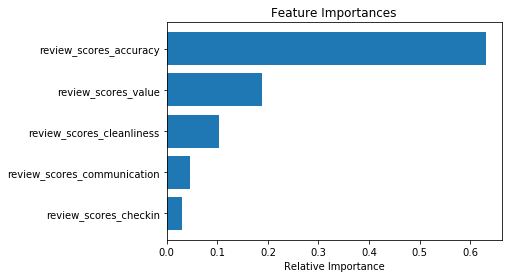

In [69]:
#Random Forest
rf_reg.fit(X_train, Y_train)
cv_rf= cross_val_score(rf_reg, X_train, Y_train, cv=5, scoring = "r2")

features = list(review)
importances = rf_reg.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

As we see in the tables above, the two first models have produced the same results. What clients prefer for the accommodation is a good value, followed by the communication with the host and the accuracy of the listing. The Support Vector Machine model produced similar results. On this model the value revie drop to second position in importance, whereas the accuracy is the most important variable. According to this model, cleanliness is also important for clients.
Random forest takes as the most important variables the value and the accuracy, the top result of the first two models and the SVM. But the other variables get a low importance, specially the communication with the host, which is well positioned on the other models. 

Below I have produced a plot with the R-squared score for each model. As we see, they all perform similar, around 0.6. This means that the model explains 60% of the changes in the dependent variable. Therefore, there are other variables not contained in the models that explain 40% of the review rating. 

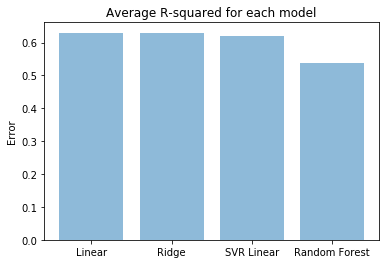

In [70]:
results_1 = cv_scores_linear_rev.mean(), cv_rid.mean(), cv_svr.mean(), cv_rf.mean()
objects_1 = ('Linear', 'Ridge', 'SVR Linear', 'Random Forest')
y_pos_1 = np.arange(len(objects_1))
plt.bar(y_pos_1, results_1, align='center', alpha=0.5)
plt.xticks(y_pos_1, objects_1)
plt.ylabel('Error')
plt.title('Average R-squared for each model')
plt.show()

<font size="4">Conclusion for the second analysis</font>

On this section, I used regression models for finding which of the review subscores explain better the final rating that the users provide. For this task I only used 5 variables I the data was not scaled. 
Although there were some differents on the results, the four models concluded that the most important variables for the guests are the value and the accuracy. As a consequence, a host that is getting bad ratings should focus primarily on offering a lower price (or improving other features if he want to maintain the price) and in providing an accurate listing, in which all the features of the property are clearly explained. 

As in the previous model, the performance is not high. But in this case, what I was looking for is finding which of these 5 features is more valued by the guests, and I consider that I have met my objective. 
